# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

# Load data

In [2]:
base_dir = "../dataset/"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

### Class wise composition of images.

In [3]:
def retrieve_classes(data_path, class_labels, dataset_name):
    # Display the dataset being processed
    print(f"---- {dataset_name} ----")
    
    severity_images = {}  # Dictionary to hold images for each class
    total_images = 0  # Counter for the total number of images

    # Loop through each class to gather images
    for i in range(len(class_labels)):
        # Get a list of images in the current class directory
        images = os.listdir(os.path.join(data_path, str(i)))
        severity_images[i] = images  # Store images in the dictionary
        total_images += len(images)  # Update total image count

    # Print the count and percentage of images for each class
    for class_index, images in severity_images.items():
        print(
            f"Grade {class_index} - {class_labels[class_index]}: {len(images)} images, "
            f"{round((len(images) * 100) / total_images, 2)}%"
        )

    return severity_images  # Return the dictionary of images by class


### Train data

In [4]:
train_set_path = os.path.join(base_dir, 'train')
train_data = retrieve_classes(train_set_path, class_names, 'Train')

---- Train ----
Grade 0 - Healthy: 2286 images, 39.56%
Grade 1 - Doubtful: 1046 images, 18.1%
Grade 2 - Minimal: 1516 images, 26.24%
Grade 3 - Moderate: 757 images, 13.1%
Grade 4 - Severe: 173 images, 2.99%


### Test data

In [5]:
valid_set_path = os.path.join(base_dir, 'val')
valid_data = retrieve_classes(valid_set_path, class_names, 'Valid')

---- Valid ----
Grade 0 - Healthy: 328 images, 39.71%
Grade 1 - Doubtful: 153 images, 18.52%
Grade 2 - Minimal: 212 images, 25.67%
Grade 3 - Moderate: 106 images, 12.83%
Grade 4 - Severe: 27 images, 3.27%


### Validation data

In [6]:
test_set_path = os.path.join(base_dir, 'test')
test_data = retrieve_classes(test_set_path, class_names, 'Test')

---- Test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


### Observations:
In all train, validation and test sets, we have adequate number of samples under "Healthy" class, but very less under "Severe" class.

### Visualize data

In [7]:
def plot_classes(dict_classes, data_path, classes, data):
    # Loop through each class and its corresponding images
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

Train data - Healthy


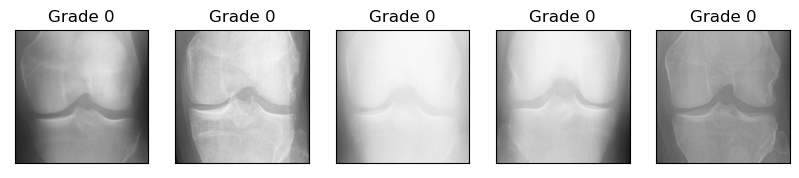

Train data - Doubtful


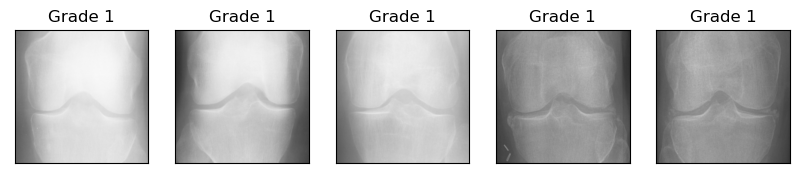

Train data - Minimal


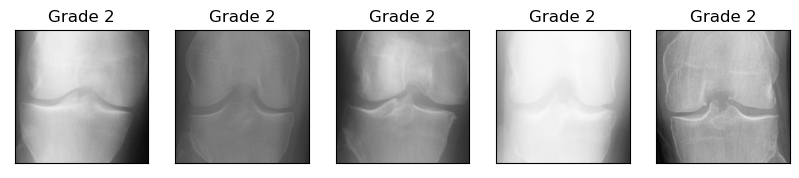

Train data - Moderate


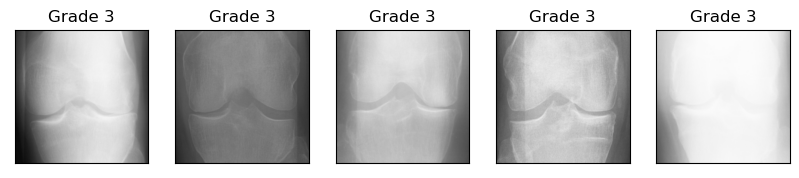

Train data - Severe


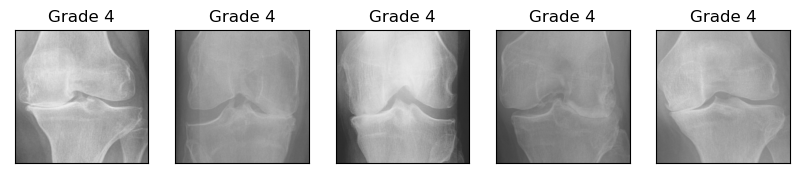

In [8]:
plot_classes(train_data, train_set_path, class_names, 'Train data')

Valid data - Healthy


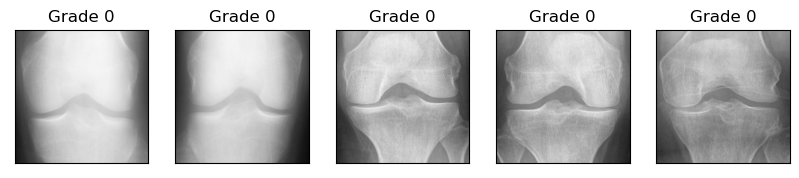

Valid data - Doubtful


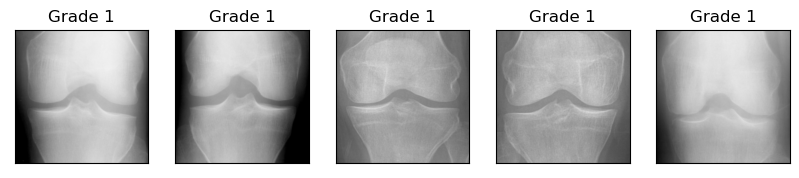

Valid data - Minimal


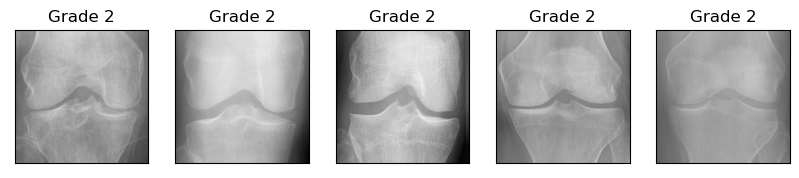

Valid data - Moderate


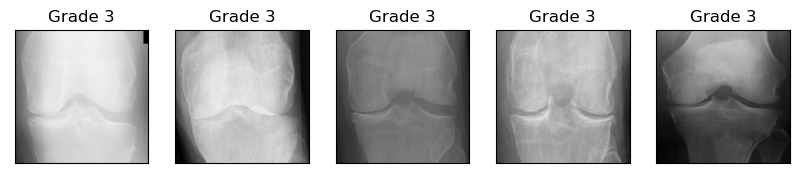

Valid data - Severe


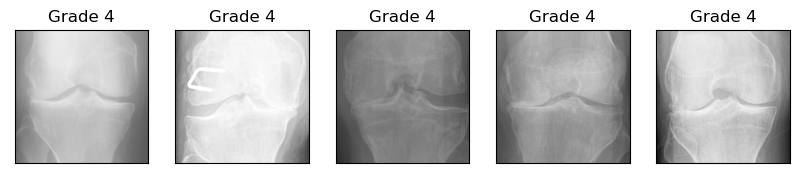

In [9]:
plot_classes(valid_data, valid_set_path, class_names, 'Valid data')

Test data - Healthy


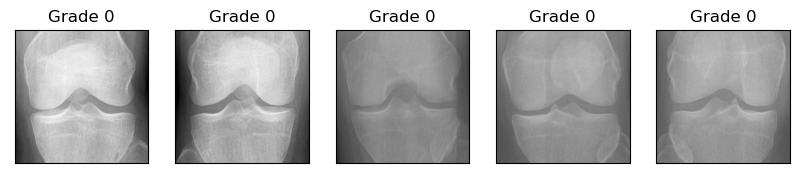

Test data - Doubtful


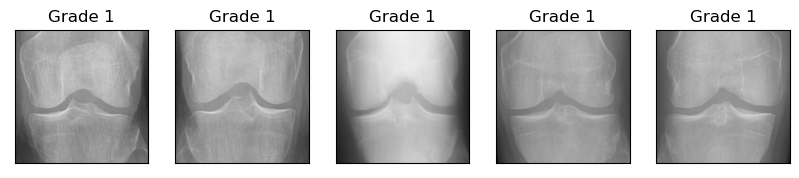

Test data - Minimal


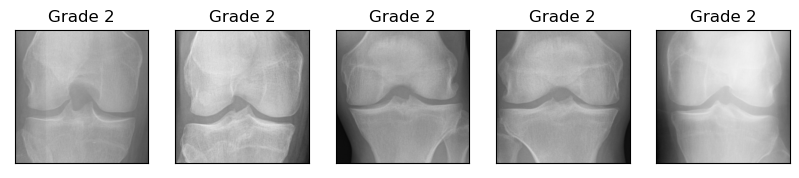

Test data - Moderate


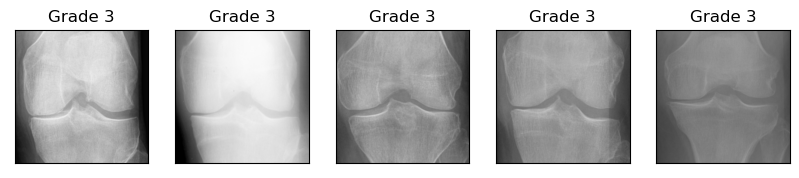

Test data - Severe


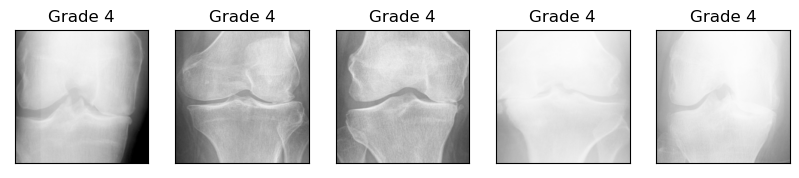

In [10]:
plot_classes(test_data, test_set_path, class_names, 'Test data')

### Observations:
It is observed that grade level(severity) increased as the gap between joints decreased or when image quality was poor or bone is deformed due to friction as fluid content is exhausted. So, we have to make sure that we do handle proper feature extraction on such types of images.

### Class distribution

It helps us to know whether our data is balanced or not, so that we can proceed with data augmentation related techniques.

In [11]:
class_mapping = {
    0: 'Healthy',
    1: 'Doubtful',
    2: 'Minimal',
    3: 'Moderate',
    4: 'Severe'
}

In [12]:
def plot_class_distribution(base_dir, class_mapping, dataset_type):
    # Count the number of images in each class directory
    class_counts = [len(os.listdir(os.path.join(base_dir, dataset_type, str(i)))) for i in range(5)]
    
    # Retrieve class labels from the class mapping for the corresponding classes
    class_labels = [class_mapping[i] for i in range(5)]
    
    # Create a bar chart to visualize the class distribution
    plt.bar(class_labels, class_counts)
    
    # Set the title and labels for the plot
    plt.title(f'{dataset_type} Set Class Distribution')  # Title of the plot
    plt.xlabel('Class')  # Label for the x-axis
    plt.ylabel('Count')  # Label for the y-axis
    
    plt.show()  # Display the plot


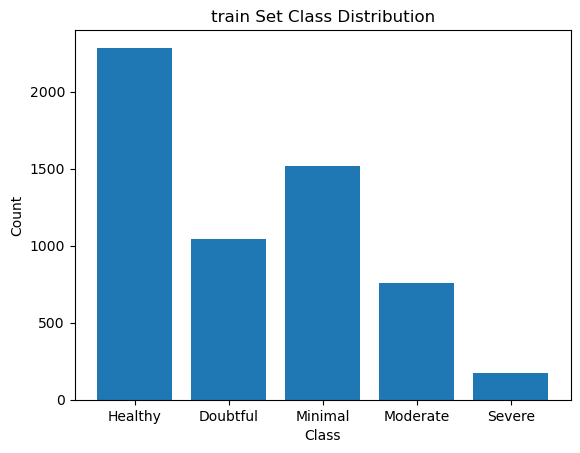

In [13]:
plot_class_distribution(base_dir, class_mapping, 'train')

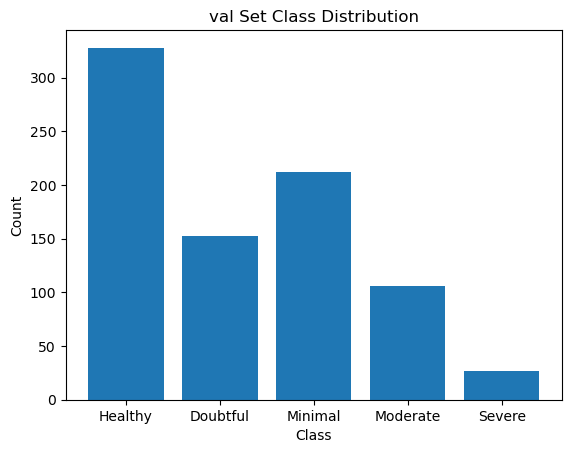

In [14]:
plot_class_distribution(base_dir, class_mapping, 'val')

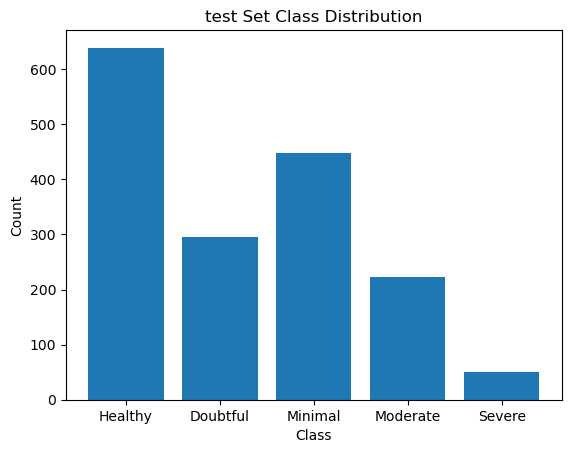

In [15]:
plot_class_distribution(base_dir, class_mapping, 'test')

### Observations:
It is observed that in all the types(train, test and validation) of data -  we have more healthy class images, less severe class images, and average minimal class images. To solve this class imbalance we have to use data augmentation techniques atleast for severe class images. 

### Dataset size

In [16]:
def dataset_size(base_dir, dataset_type):
    total_images = 0
    for i in range(5):  # Since the classes are labeled from 0 to 4
        class_dir = os.path.join(base_dir, dataset_type, str(i))
        total_images += len(os.listdir(class_dir))
    print(f'{dataset_type.capitalize()} set has {total_images} images.')

In [17]:
# Usage for each split
dataset_size(base_dir, 'train')
dataset_size(base_dir, 'val')
dataset_size(base_dir, 'test')

Train set has 5778 images.
Val set has 826 images.
Test set has 1656 images.


Available number of samples may be sufficient enough for model training. Even though, we can use augmentation for better results.

### No. of features - Pixel values of the images

The number of features per image is typically calculated by the width, height, and color channels.

In [18]:
def average_image_size(base_dir, dataset_type):
    total_pixels = 0  # Initialize a counter for total pixel count
    num_images = 0  # Initialize a counter for the number of images

    # Iterate through each class directory (0 to 4)
    for i in range(5):
        class_dir = os.path.join(base_dir, dataset_type, str(i))  
        
        # Loop through each image file in the class directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)  # Get the full image path
            
            with Image.open(img_path) as img:  # Open the image file
                width, height = img.size  # Get the dimensions of the image
                # Calculate total pixels (width * height * number of channels)
                total_pixels += width * height * len(img.getbands())  # getbands() returns the number of channels
                num_images += 1  # Increment the image counter

    # Calculate the average number of pixels per image
    avg_pixels = total_pixels / num_images if num_images > 0 else 0
    print(f'Average number of features (pixels * channels) in the {dataset_type} set: {avg_pixels}')

In [19]:
# Usage for each dataset split
average_image_size(base_dir, 'train')  # Calculate for training set
average_image_size(base_dir, 'val')    # Calculate for validation set
average_image_size(base_dir, 'test')   # Calculate for test set

Average number of features (pixels * channels) in the train set: 50176.0
Average number of features (pixels * channels) in the val set: 50176.0
Average number of features (pixels * channels) in the test set: 50176.0


### Observations:
1. Consistent data splits - Train, validation and test sets maintain the same image dimensions and the format.
2. Uniform image size - All images are 224x224 pixels in gray scale(L mode), resulting in 50,176 features per image(224x224) 

### Image mode
Usually mode is either "RGB" or "L" for grayscale.

In [20]:
def check_data_type(base_dir, dataset_type):
    class_dir = os.path.join(base_dir, dataset_type, '0')  # Check in class '0' as an example
    img_file = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_file)
    with Image.open(img_path) as img:
        print(f'Data type of pixel values: {img.mode}')

In [21]:
check_data_type(base_dir, 'train')

Data type of pixel values: L


In [22]:
check_data_type(base_dir, 'test')

Data type of pixel values: L


In [23]:
check_data_type(base_dir, 'val')

Data type of pixel values: L


All the data samples are in grayscale model only.

### Brightness vs Contrast
Helps to understand the image quality.

In [24]:
def calculate_brightness_contrast(base_dir, dataset_type):
    brightness_values = []  # List to store brightness values
    contrast_values = []    # List to store contrast values

    # Iterate through each class directory (0 to 4)
    for i in range(5):
        class_dir = os.path.join(base_dir, dataset_type, str(i))  # Path to current class directory
        
        # Loop through each image file in the class directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)  # Full image path
            
            with Image.open(img_path) as img:
                img_array = np.array(img)  # Convert image to a NumPy array
                
                # Calculate brightness as the mean pixel value
                brightness = np.mean(img_array)
                brightness_values.append(brightness)
                
                # Calculate contrast as the standard deviation of pixel values
                contrast = np.std(img_array)
                contrast_values.append(contrast)

    # Calculate average brightness and contrast
    avg_brightness = np.mean(brightness_values)
    avg_contrast = np.mean(contrast_values)
    return avg_brightness, avg_contrast, brightness_values, contrast_values


In [25]:
def plot_brightness_contrast(base_dir, dataset_type):
    avg_brightness, avg_contrast, brightness_values, contrast_values = calculate_brightness_contrast(base_dir, dataset_type)

    # Plot brightness vs. contrast
    plt.figure(figsize=(12, 6))
    plt.scatter(brightness_values, contrast_values, alpha=0.6)
    plt.title(f'Brightness vs Contrast in {dataset_type} Set')
    plt.xlabel('Brightness (Mean Pixel Value)')
    plt.ylabel('Contrast (Standard Deviation of Pixel Values)')
    plt.grid()
    plt.axhline(y=avg_contrast, color='r', linestyle='--', label=f'Avg Contrast: {avg_contrast:.2f}')
    plt.axvline(x=avg_brightness, color='g', linestyle='--', label=f'Avg Brightness: {avg_brightness:.2f}')
    plt.legend()
    plt.show()

    # Print average scores
    print(f'Average Brightness in {dataset_type} set: {avg_brightness:.2f}')
    print(f'Average Contrast in {dataset_type} set: {avg_contrast:.2f}')

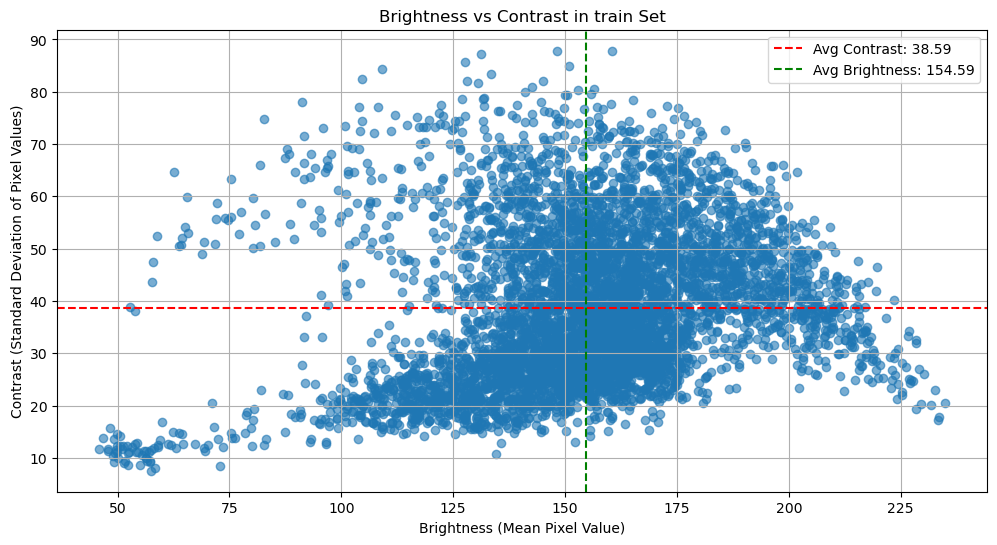

Average Brightness in train set: 154.59
Average Contrast in train set: 38.59


In [26]:
plot_brightness_contrast(base_dir, 'train')  # Plot for training set

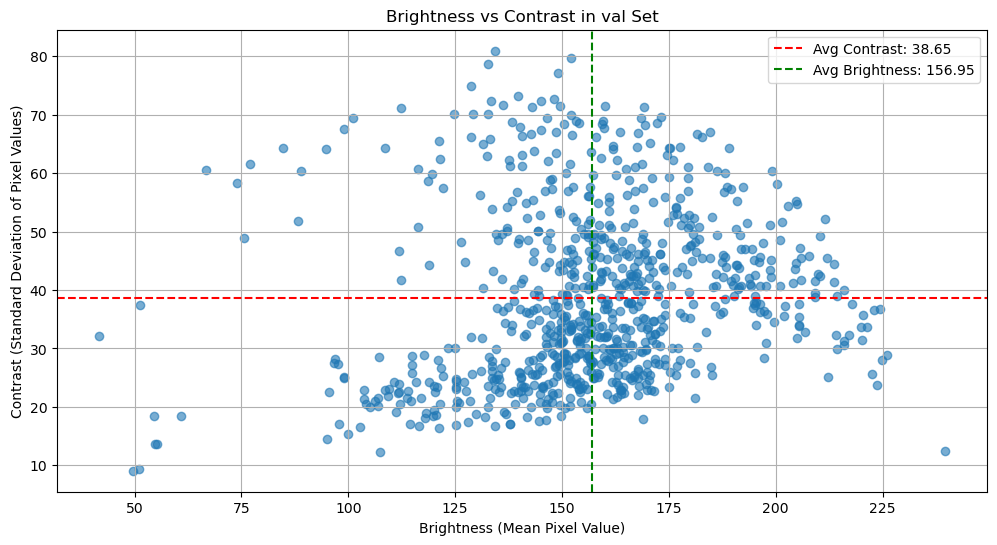

Average Brightness in val set: 156.95
Average Contrast in val set: 38.65


In [27]:
plot_brightness_contrast(base_dir, 'val')    # Plot for validation set

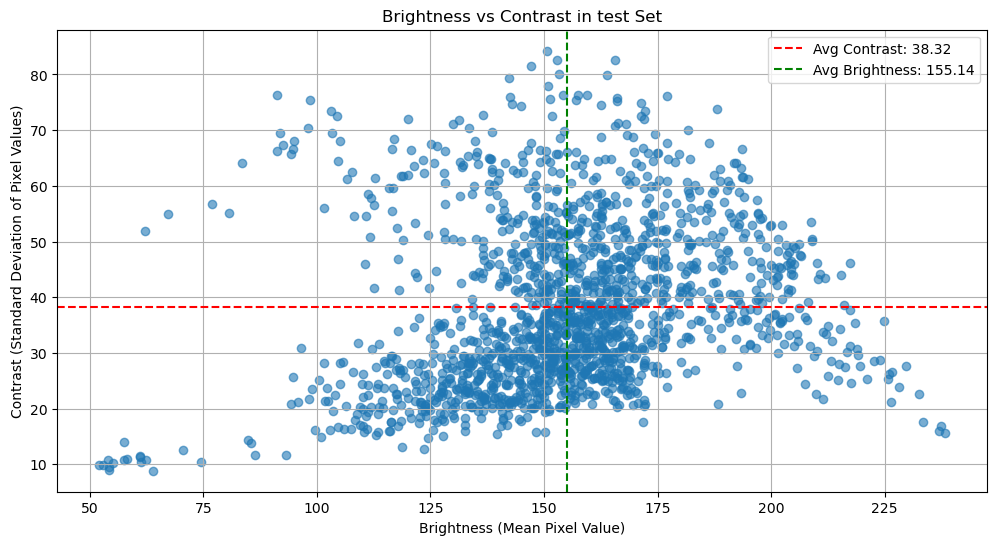

Average Brightness in test set: 155.14
Average Contrast in test set: 38.32


In [28]:
plot_brightness_contrast(base_dir, 'test')   # Plot for test set

### Observations:

The average brightness and contrast values across the training, validation, and test sets indicate generally good image quality, crucial for effective model training and evaluation. The training set has an average brightness of **154.59** and contrast of **38.59**, while the validation set shows slightly improved values at **156.95** for brightness and **38.65** for contrast. The test set, with an average brightness of **155.14** and contrast of **38.32**, reflects good visibility but exhibits a slight decrease in contrast compared to the other sets. Overall, while the brightness levels are consistent and favorable, the marginal variations in contrast suggest that enhancing contrast across all datasets may further improve feature differentiation and model performance.

With this,
1. We have understood basic details about the dataset, such as the size, number of features, composition, and data types.
2. We have displayed a few samples from the dataset.